In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install sklearn
!pip install seaborn
!pip install requests

In [13]:
#Import basic libraries
import pandas as pd
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
import json
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### 1. CryptoCompare API call for historical Hours 
### Function for CryptoCompare HistoMinute API request

In [14]:


def get_histohour_data(exchange, fromPair, toPair):
    url = 'https://min-api.cryptocompare.com/data/histohour?fsym={}&tsym={}&limit=2000&aggregate=1&e={}'
    response = requests.post(url.format(fromPair, toPair, exchange))
    data = json.loads(response.content)
    df = pd.DataFrame.from_dict(data["Data"], orient="columns")
    
    return pd.DataFrame(df)

In [15]:
# json list to pandas dataframe
price_data = {}
pairs = ['LTC','BCH','ETC','ETH','LSK','OMG','XMR','XRP','ZEC']
for pair in pairs:
    price_data[pair] = get_histohour_data('Poloniex', pair, 'BTC')

In [16]:
price_data['ETC'].head()

,close,high,low,open,time,volumefrom,volumeto
0,0.002128,0.002145,0.002072,0.002072,1524632400,16124.43,34.17
1,0.002166,0.002176,0.002126,0.002128,1524636000,4460.78,9.65
2,0.002151,0.002181,0.002146,0.002166,1524639600,3410.19,7.39
3,0.002115,0.002168,0.002108,0.002151,1524643200,2237.01,4.78
4,0.002099,0.002136,0.002086,0.002115,1524646800,7180.46,15.10


### Function to merge dataframes into a single dataframe
* dataframes: multiple dataframe inside of dictionary*
* labels: dictionary's labels*
* col: column to merge into a new dataframe*

In [17]:
def merge_dfs_on_column(dataframes, labels, col): 
    '''Merge a single column of each dataframe into a new combined dataframe'''
    series_dict = {}
    for index in range(len(dataframes)): #index = rowIndex
        series_dict[labels[index]] = dataframes[index][col]
        
    return pd.DataFrame(series_dict)

In [18]:
# Merge each coin's close price
df = merge_dfs_on_column(list(price_data.values()), list(price_data.keys()), 'close')

In [19]:
df.head()

,LTC,BCH,ETC,ETH,LSK,OMG,XMR,XRP,ZEC
0,0.01656,0.1401,0.002128,0.06996,0.001268,0.001759,0.02891,0.000091,0.03094
1,0.01654,0.1448,0.002166,0.07030,0.001265,0.001750,0.02912,0.000092,0.03138
2,0.01649,0.1439,0.002151,0.07012,0.001270,0.001773,0.02892,0.000092,0.03100
3,0.01633,0.1394,0.002115,0.06884,0.001254,0.001748,0.02840,0.000090,0.03080
4,0.01632,0.1412,0.002099,0.06859,0.001237,0.001748,0.02821,0.000090,0.03034


### Shift price data and label each coin's next price column

In [21]:
for pair in pairs:
    df[pair+"next"] = df[pair].shift(-1)

In [22]:
df.columns

Index(['LTC', 'BCH', 'ETC', 'ETH', 'LSK', 'OMG', 'XMR', 'XRP', 'ZEC',
       'LTCnext', 'BCHnext', 'ETCnext', 'ETHnext', 'LSKnext', 'OMGnext',
       'XMRnext', 'XRPnext', 'ZECnext'],
      dtype='object')

In [23]:
# Label the next price movevements for each coin
for pair in pairs:
    df[pair+'move'] = '0'
    df.loc[df[pair] < df[pair+'next'], pair+'move'] = '1'
    df.loc[df[pair] > df[pair+'next'], pair+'move'] = '-1'
    df.loc[df[pair] == df[pair+'next'], pair+'move'] = '0'

In [24]:
df2 = df[['BCHmove', 'ETCmove', 'ETHmove', 'LSKmove', 'LTCmove', 'OMGmove', 'XMRmove', 'XRPmove', 'ZECmove']].copy()
df2 = df2.apply(pd.to_numeric)

In [25]:
df2.corr()

,BCHmove,ETCmove,ETHmove,LSKmove,LTCmove,OMGmove,XMRmove,XRPmove,ZECmove
BCHmove,1.000000,0.282203,0.357545,0.113216,0.248581,0.107976,0.102442,0.299241,0.124959
ETCmove,0.282203,1.000000,0.268485,0.077872,0.180235,0.104304,0.143947,0.202865,0.096206
ETHmove,0.357545,0.268485,1.000000,0.094036,0.285476,0.146126,0.112171,0.327544,0.108691
LSKmove,0.113216,0.077872,0.094036,1.000000,0.079073,0.096539,0.054806,0.119904,0.043993
LTCmove,0.248581,0.180235,0.285476,0.079073,1.000000,0.112854,0.137312,0.241122,0.142230
OMGmove,0.107976,0.104304,0.146126,0.096539,0.112854,1.000000,0.095629,0.131803,0.052919
XMRmove,0.102442,0.143947,0.112171,0.054806,0.137312,0.095629,1.000000,0.124952,0.088737
XRPmove,0.299241,0.202865,0.327544,0.119904,0.241122,0.131803,0.124952,1.000000,0.119807
ZECmove,0.124959,0.096206,0.108691,0.043993,0.142230,0.052919,0.088737,0.119807,1.000000


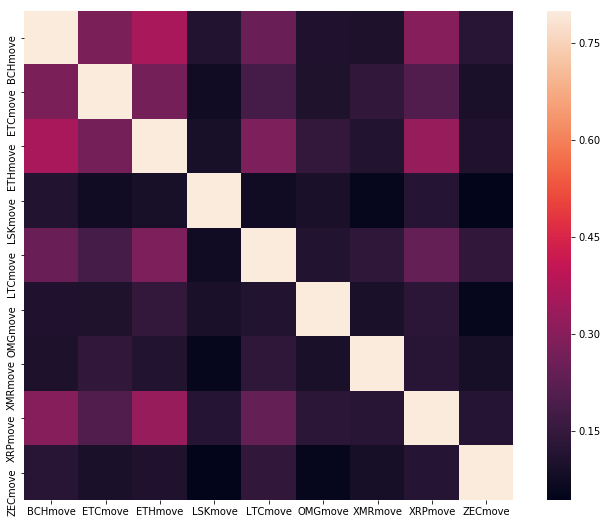

In [29]:
corrmat = df2.corr()
f,ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);